# TensorFlow Assignment: Playing with cGANs

**[Duke Community Standard](http://integrity.duke.edu/standard.html): By typing your name below, you are certifying that you have adhered to the Duke Community Standard in completing this assignment.**

Name: Khoi D. Vo </br>
Date: June 29, 2018

### Conditioning on the class label

In class, we drew a random noise vector $z$, and passed it into the Generator. This gave us very little control over the images we generated. Suppose we wanted to be able to generate a random image of a two, or of a three. In other words, we want to train the model to know how to draw whatever digit we tell it to. How could you alter the training procedure to make this work? Implement a conditional GAN, and use it to generate twos or threes.

In particular,

1. Modify the code from class to take placeholder inputs (real images and z values) that are 10 elements longer.
2. Modify the next_feed_dict to concatenate labels (one-hot, ten-dimensional) to the noise inputs and image inputs.
3. Train the GAN.
4. Try making the GAN generate a few ones, then a few threes, by concatenating `[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]` or `[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]`, say, to your noise vectors. How does it do?

In [26]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
def variables_from_scope(scope_name):
    return tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=scope_name)

def visualize_row(images, img_width=28, cmap='gray'):
    im = np.reshape(images, [-1, img_width])
    plt.figure()
    plt.imshow(im, cmap=cmap)
    plt.show()

In [4]:
# Graph parameters
epsilon_dim = 42
hidden_dim = 256
image_size = 784

# Training parameters
batch_size = 50
iterations = 25000

In [6]:
# Generator
def generator(epsilon,labels):
    ep_inputs = tf.concat([epsilon,labels],axis=1)
    
    hidden_layer = tf.layers.dense(ep_inputs, hidden_dim, activation=tf.nn.relu)
    out_layer = tf.layers.dense(hidden_layer, image_size, activation=tf.sigmoid)
    return out_layer # fake image generated

In [11]:
def discriminator(images, labels):
    img_inputs = tf.concat([images,labels],axis=1)

    hidden_layer = tf.layers.dense(img_inputs, hidden_dim, name='d_hidden', activation=tf.nn.relu)
    out_layer = tf.layers.dense(hidden_layer, 1, name='d_out', activation=tf.sigmoid)
    return out_layer

In [12]:
tf.reset_default_graph()

# Placeholders
inputs_g = tf.placeholder(tf.float32, [None, epsilon_dim])
labels = tf.placeholder(tf.float32, [None, 10])
inputs_d = tf.placeholder(tf.float32, [None, image_size])

# Generator
with tf.variable_scope("generator") as scope:
    gen_image = generator(inputs_g,labels)

# Discriminator
with tf.variable_scope("discriminator") as scope:
    d_fake = discriminator(gen_image,labels)
    scope.reuse_variables()
    d_real = discriminator(inputs_d,labels)

g_loss = -tf.reduce_mean(tf.log(d_fake))
d_loss = -tf.reduce_mean(tf.log(d_real) + tf.log(1. - d_fake))

optimize_g = tf.train.AdamOptimizer().minimize(g_loss, var_list=variables_from_scope("generator"))
optimize_d = tf.train.AdamOptimizer().minimize(d_loss, var_list=variables_from_scope("discriminator"))

initialize_all = tf.global_variables_initializer()

In [13]:
# Train the GAN.
def make_noise():
    return np.random.uniform(-1.0, 1.0, [batch_size, epsilon_dim])

sess = tf.Session()
sess.run(initialize_all)

start_time = time.time()
for t in range(iterations):
    batch_x, batch_y = mnist.train.next_batch(batch_size)
    epsilon = make_noise()
    
    feed_dict = {inputs_g: epsilon,
                 inputs_d: batch_x,
                 labels: batch_y}
    
    _, _, loss, fake_data = sess.run([optimize_g, optimize_d, d_loss, gen_image], feed_dict=feed_dict)

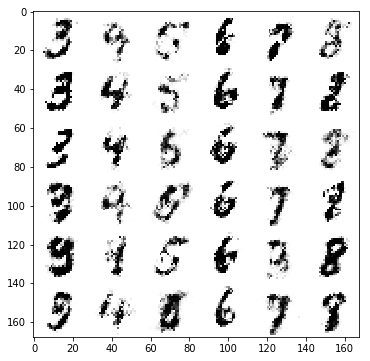

In [20]:
# Testing
# Generate images from noise, using the generator network.
n = 6
canvas = np.empty((28 * n, 28 * n))
for i in range(n):
    # Noise input.
    z = np.random.uniform(-1., 1., size=[n, epsilon_dim])
    z_labels = np.eye(10)
    
    # Generate image from noise.
    g = sess.run(gen_image, feed_dict={inputs_g: z, labels: z_labels[3:9]})
    # Reverse colours for better display
    g = -1 * (g - 1)
    for j in range(n):
        # Draw the generated digits
        canvas[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = g[j].reshape([28, 28])

plt.figure(figsize=(n, n))
plt.imshow(canvas, origin="upper", cmap="gray")
plt.show()

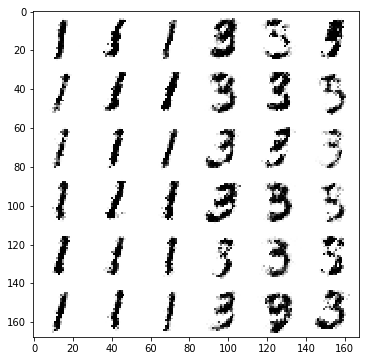

In [25]:
to_test = [[0,1,0,0,0,0,0,0,0,0],[0,1,0,0,0,0,0,0,0,0],[0,1,0,0,0,0,0,0,0,0],
           [0,0,0,1,0,0,0,0,0,0],[0,0,0,1,0,0,0,0,0,0],[0,0,0,1,0,0,0,0,0,0]]

n = 6
canvas = np.empty((28 * n, 28 * n))
for i in range(n):
    # Noise input.
    z = np.random.uniform(-1., 1., size=[n, epsilon_dim])
    z_labels = np.eye(10)
    
    # Generate image from noise.
    g = sess.run(gen_image, feed_dict={inputs_g: z, labels: to_test})
    # Reverse colours for better display
    g = -1 * (g - 1)
    for j in range(n):
        # Draw the generated digits
        canvas[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = g[j].reshape([28, 28])

plt.figure(figsize=(n, n))
plt.imshow(canvas, origin="upper", cmap="gray")
plt.show()